cuda
torch.Size([100, 1, 28, 28]) torch.Size([100])
epoch 1 / 2, step 100/600, loss = 0.3511
epoch 1 / 2, step 200/600, loss = 0.1848
epoch 1 / 2, step 300/600, loss = 0.1888
epoch 1 / 2, step 400/600, loss = 0.1817
epoch 1 / 2, step 500/600, loss = 0.0879
epoch 1 / 2, step 600/600, loss = 0.2389
epoch 2 / 2, step 100/600, loss = 0.0931
epoch 2 / 2, step 200/600, loss = 0.2478
epoch 2 / 2, step 300/600, loss = 0.0688
epoch 2 / 2, step 400/600, loss = 0.0847
epoch 2 / 2, step 500/600, loss = 0.0854
epoch 2 / 2, step 600/600, loss = 0.0804
accuracy = 96.51


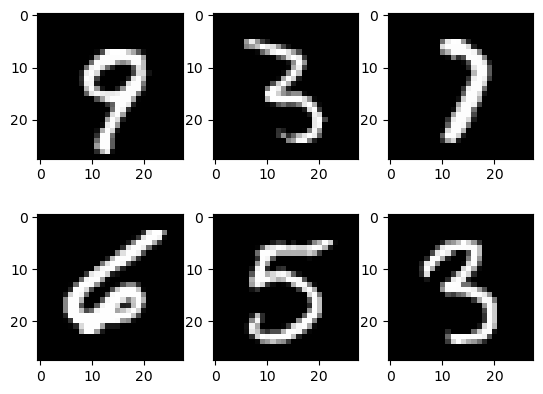

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

import sys
from torch.utils.tensorboard import SummaryWriter

# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

writer = SummaryWriter("runs/mnist2")

# hyper parameters
input_size = 784 # 28x28
hidden_size = 100
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.01

# MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', 
    train=True, transform=transforms.ToTensor(), download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
    train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
    batch_size=batch_size, shuffle=False)

examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')
#plt.show()
img_grid = torchvision.utils.make_grid(samples)
writer.add_image('mnist_images', img_grid)
writer.close()

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

writer.add_graph(model, samples.reshape(-1, 28*28).to(device))
writer.close()

# training loop
n_total_steps = len(train_loader)
running_loss = 0.0
running_correct = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 100, 1, 28, 28
        # 100, 784
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backwards
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        running_correct += (predictions == labels).sum().item()

        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')
            
            writer.add_scalar('training loss', running_loss / 100, epoch * n_total_steps + i)
            writer.add_scalar('accuracy', running_correct / 100, epoch * n_total_steps + i)
            running_loss = 0.0
            running_correct = 0
writer.close()

# test

labels_p = []
preds_p = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)

        # value, index
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()

        class_predictions = [F.softmax(o, dim=0) for o in outputs]

        preds_p.append(class_predictions)
        labels_p.append(predictions)

    preds_p = torch.cat([torch.stack(batch) for batch in preds_p]) # 1000x10
    labels_p = torch.cat(labels_p) # 1000x1

    acc = 100.0 * n_correct / n_samples
    print(f'accuracy = {acc}')

    classes = range(10)
    for i in classes:
        labels_i = labels_p == i
        preds_i = preds_p[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        writer.close()